In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Cuaca = pd.read_csv('https://raw.githubusercontent.com/FairuzAldaPerkasa/Dataset/refs/heads/main/seattle-weather.csv')
Pasut = pd.read_csv("https://raw.githubusercontent.com/FairuzAldaPerkasa/Dataset/refs/heads/main/DataPasut.csv", delimiter=";")

In [ ]:
Cuaca.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [ ]:
Pasut.head()

,Time (UTC),bat(V),pr2(m),prs(m),rad(m)
0,01/12/2022 00:00,NaN,"0,568",1,"7,236"
1,01/12/2022 00:01,NaN,"0,558","1,001","7,231"
2,01/12/2022 00:02,NaN,"0,557","1,003","7,235"
3,01/12/2022 00:03,NaN,"0,568","1,001","7,24"
4,01/12/2022 00:04,NaN,"0,575","1,013","7,248"


In [ ]:
Pasut.columns
Pasut = Pasut.drop(columns=['bat(V)'])
Pasut = Pasut.fillna(method='ffill').fillna(method='bfill')
Pasut[['pr2(m)', 'prs(m)', 'rad(m)']] = Pasut[['pr2(m)', 'prs(m)', 'rad(m)']].replace({',': '.'}, regex=True)

<ipython-input-8-32c99e5d3b59>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Pasut = Pasut.fillna(method='ffill').fillna(method='bfill')


In [ ]:
Pasut

,Time (UTC),pr2(m),prs(m),rad(m)
0,01/12/2022 00:00,0.568,1,7.236
1,01/12/2022 00:01,0.558,1.001,7.231
2,01/12/2022 00:02,0.557,1.003,7.235
3,01/12/2022 00:03,0.568,1.001,7.24
4,01/12/2022 00:04,0.575,1.013,7.248
...,...,...,...,...
42483,31/12/2022 23:55,0.585,1.143,7.257
42484,31/12/2022 23:56,0.589,1.134,7.254
42485,31/12/2022 23:57,0.599,1.148,7.253
42486,31/12/2022 23:58,0.591,1.148,7.26


In [ ]:
Cuaca.isnull().sum()

,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


In [ ]:
Pasut.isnull().sum()

,0
Time (UTC),0
pr2(m),0
prs(m),0
rad(m),0


In [ ]:
Cuaca.duplicated().sum()

0

In [ ]:
Pasut.duplicated().sum()

0

In [ ]:
def classify_pasut(row):
    try:
        wave_height = float(row['pr2(m)'].replace(',', '.')) if pd.notnull(row['pr2(m)']) else None
        pressure = float(row['prs(m)']) if pd.notnull(row['prs(m)']) else None
    except (ValueError, KeyError) as e:
        print(f"Error: {e}, Row: {row}")
        return 0


    # Logika Klasifikasi
    if wave_height is None or pressure is None:
        return 0

    # Tidak aman
    if wave_height > 1.5 or pressure < 1.000:
        return 0

    # Risiko sedang
    if 1.0 < wave_height <= 1.5 or 1000 <= pressure <= 1.010:
        return 1

    # Aman
    if wave_height <= 1.0 and pressure > 1.010:
        return 2

    return 0

Pasut['Pasut_Aman'] = Pasut.apply(classify_pasut, axis=1)



In [ ]:
def classify_weather_debug(row):
    try:
        wind = row['wind'] if pd.notnull(row['wind']) else None
        weather = row['weather'].lower() if pd.notnull(row['weather']) else None
        precipitation = row['precipitation'] if pd.notnull(row['precipitation']) else None
    except KeyError:
        return 0

    print(f"Wind: {wind}, Weather: {weather}, Precipitation: {precipitation}")  # Debug

    if wind > 20 or weather in ['rain', 'snow'] or precipitation > 100:
        return 0
    if 10 <= wind <= 20 or weather in ['fog', 'drizzle'] or 50 <= precipitation <= 100:
        return 1
    if wind < 10 and weather in ['sun'] and precipitation == 0.0:
        return 2

    return 0

Cuaca['Cuaca_Aman'] = Cuaca.apply(classify_weather_debug, axis=1)

# Periksa distribusi hasil debug
print(Cuaca['Cuaca_Aman'].value_counts())


Wind: 4.7, Weather: drizzle, Precipitation: 0.0
Wind: 4.5, Weather: rain, Precipitation: 10.9
Wind: 2.3, Weather: rain, Precipitation: 0.8
Wind: 4.7, Weather: rain, Precipitation: 20.3
Wind: 6.1, Weather: rain, Precipitation: 1.3
Wind: 2.2, Weather: rain, Precipitation: 2.5
Wind: 2.3, Weather: rain, Precipitation: 0.0
Wind: 2.0, Weather: sun, Precipitation: 0.0
Wind: 3.4, Weather: rain, Precipitation: 4.3
Wind: 3.4, Weather: rain, Precipitation: 1.0
Wind: 5.1, Weather: sun, Precipitation: 0.0
Wind: 1.9, Weather: sun, Precipitation: 0.0
Wind: 1.3, Weather: sun, Precipitation: 0.0
Wind: 5.3, Weather: snow, Precipitation: 4.1
Wind: 3.2, Weather: snow, Precipitation: 5.3
Wind: 5.0, Weather: snow, Precipitation: 2.5
Wind: 5.6, Weather: snow, Precipitation: 8.1
Wind: 5.0, Weather: snow, Precipitation: 19.8
Wind: 1.6, Weather: snow, Precipitation: 15.2
Wind: 2.3, Weather: snow, Precipitation: 13.5
Wind: 8.2, Weather: rain, Precipitation: 3.0
Wind: 4.8, Weather: rain, Precipitation: 6.1
Wind: 

In [ ]:
Cuaca


,date,precipitation,temp_max,temp_min,wind,weather,Cuaca_Aman
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,1
1,2012-01-02,10.9,10.6,2.8,4.5,rain,0
2,2012-01-03,0.8,11.7,7.2,2.3,rain,0
3,2012-01-04,20.3,12.2,5.6,4.7,rain,0
4,2012-01-05,1.3,8.9,2.8,6.1,rain,0
...,...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain,0
1457,2015-12-28,1.5,5.0,1.7,1.3,rain,0
1458,2015-12-29,0.0,7.2,0.6,2.6,fog,1
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun,2


In [ ]:
# Hapus kolom yang tidak relevan dari Pasut dan Cuaca
kolom_pasut = ['pr2(m)', 'prs(m)', 'Pasut_Aman']  # Kolom yang dibutuhkan dari Pasut
kolom_cuaca = ['precipitation', 'wind', 'weather', 'Cuaca_Aman']  # Kolom yang dibutuhkan dari Cuaca

# Filter kolom pada masing-masing dataset
Pasut_bersih = Pasut[kolom_pasut]
Cuaca_bersih = Cuaca[kolom_cuaca]

# Dataset Gabungan
gabungan = pd.DataFrame()

# Gabungkan data berdasarkan klasifikasi keamanan
for klasifikasi in [0, 1, 2]:
    # Filter data dari Pasut dan Cuaca sesuai klasifikasi
    pasut_filtered = Pasut_bersih[Pasut_bersih['Pasut_Aman'] == klasifikasi].reset_index(drop=True)
    cuaca_filtered = Cuaca_bersih[Cuaca_bersih['Cuaca_Aman'] == klasifikasi].reset_index(drop=True)

    # Gabungkan data yang memiliki klasifikasi sama
    combined = pd.concat([pasut_filtered, cuaca_filtered], axis=1)

    # Tambahkan kolom klasifikasi keamanan gabungan
    combined['Aman_Melaut'] = klasifikasi

    # Tambahkan ke dataset gabungan
    gabungan = pd.concat([gabungan, combined], axis=0)

# Reset indeks dataset gabungan
gabungan.reset_index(drop=True, inplace=True)

# Hapus kolom 'Pasut_Aman' dan 'Cuaca_Aman'
gabungan = gabungan.drop(columns=['Pasut_Aman', 'Cuaca_Aman'], errors='ignore')

# Periksa hasil
print("Dataset Gabungan Setelah Menghapus Kolom Tidak Relevan:")
print(gabungan.head())

# Simpan hasil jika diperlukan
gabungan.to_csv('gabungan_data_final.csv', index=False)

# Periksa distribusi safe_to_sail
print("Distribusi Klasifikasi Gabungan:")
print(gabungan['Aman_Melaut'].value_counts())


Dataset Gabungan Setelah Menghapus Kolom Tidak Relevan:
  pr2(m) prs(m)  precipitation  wind weather  Aman_Melaut
0  0.568      1           10.9   4.5    rain            0
1  0.558  1.001            0.8   2.3    rain            0
2  0.557  1.003           20.3   4.7    rain            0
3  0.568  1.001            1.3   6.1    rain            0
4  0.558  0.979            2.5   2.2    rain            0
Distribusi Klasifikasi Gabungan:
Aman_Melaut
0    28062
2    13651
1      775
Name: count, dtype: int64


In [ ]:
gabungan.dropna()

,pr2(m),prs(m),precipitation,wind,weather,Aman_Melaut
0,0.568,1,10.9,4.5,rain,0
1,0.558,1.001,0.8,2.3,rain,0
2,0.557,1.003,20.3,4.7,rain,0
3,0.568,1.001,1.3,6.1,rain,0
4,0.558,0.979,2.5,2.2,rain,0
...,...,...,...,...,...,...
29472,0.736,1.182,0.0,1.0,sun,2
29473,0.737,1.176,0.0,1.7,sun,2
29474,0.745,1.171,0.0,2.5,sun,2
29475,0.74,1.182,0.0,3.4,sun,2


In [ ]:
gabungan = gabungan.dropna()
print(gabungan.isnull().sum())

pr2(m)           0
prs(m)           0
precipitation    0
wind             0
weather          0
Aman_Melaut      0
dtype: int64


In [ ]:
print(gabungan['Aman_Melaut'].value_counts())

Aman_Melaut
0    667
2    640
1    154
Name: count, dtype: int64


In [ ]:
from google.colab import files
gabungan.to_csv('gabungan_data_final.csv', index=False)
# Untuk file CSV
files.download('gabungan_data_final.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip3 install KMeans
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



In [ ]:

# Fitur numerik untuk normalisasi
numerical_features = ['pr2(m)', 'prs(m)', 'precipitation', 'wind']

# Normalisasi data
scaler = MinMaxScaler()
gabungan[numerical_features] = scaler.fit_transform(gabungan[numerical_features])

# Panjang sequence untuk LSTM
sequence_length = 10

# Membentuk data time-series
data_sequences = []
for i in range(len(gabungan) - sequence_length):
    sequence = gabungan[numerical_features].iloc[i:i + sequence_length].values
    data_sequences.append(sequence)

data_sequences = np.array(data_sequences)

# Pastikan hasil data time-series
print(f"Shape of data_sequences: {data_sequences.shape}")


Shape of data_sequences: (1451, 10, 4)


In [ ]:
# Input untuk LSTM
X = data_sequences[:-1]  # Semua kecuali yang terakhir
y = data_sequences[1:, -1, :]  # Hanya prediksi nilai terakhir di setiap sequence

# Verifikasi bentuk data
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")

Shape X: (1450, 10, 4)
Shape y: (1450, 4)


In [ ]:
from tensorflow.keras.regularizers import L1L2

lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape=(sequence_length, len(numerical_features)),
                    kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(64, return_sequences=False,
                    kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(len(numerical_features), activation='linear'))
lstm_model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)


class StopTrainingAtLoss(Callback):
    def __init__(self, target_loss):
        super(StopTrainingAtLoss, self).__init__()
        self.target_loss = target_loss

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        if current_loss and current_loss < self.target_loss:
            print(f"\nLoss sudah di bawah {self.target_loss:.2f}. Menghentikan pelatihan.")
            self.model.stop_training = True


In [ ]:
stop_at_loss = StopTrainingAtLoss(target_loss=0.0085)

# Latih model dengan callback
history = lstm_model.fit(
    X, y,
    epochs=30,
    batch_size=16,
    verbose=1,
    callbacks=[stop_at_loss, reduce_lr]
)


# Simpan model jika diperlukan
lstm_model.save('lstm_model.h5')
print("Model LSTM telah disimpan.")


Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.1206 - learning_rate: 0.0010
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0626 - learning_rate: 0.0010
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0511 - learning_rate: 0.0010
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0468 - learning_rate: 0.0010
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0412 - learning_rate: 0.0010
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0376 - learning_rate: 0.0010
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0344 - learning_rate: 0.0010
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0311 - learning_rate: 0.0010
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0291 - learning_rate: 0.0010
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0280 - learning_rate: 0.0010
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0249 - learning_rate: 0.0010
Epoch 1

Model LSTM telah disimpan.


In [ ]:
# Membuat encoder dari LSTM (tanpa lapisan output)
encoder = Sequential(lstm_model.layers[:-1])  # Hapus lapisan Dense
latent_features = encoder.predict(X)

# Pastikan bentuk representasi laten
print(f"Shape of latent_features: {latent_features.shape}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Shape of latent_features: (1450, 64)


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)  # adjust number of clusters as needed
clusters = kmeans.fit_predict(latent_features)

# Now your original code should work:
# Potong dataset ke panjang yang sesuai
gabungan_trimmed = gabungan.iloc[(sequence_length - 1):(sequence_length - 1 + len(clusters))].copy()

# Tetapkan hasil cluster
gabungan_trimmed['Cluster'] = clusters

# Simpan hasil jika diperlukan
gabungan_trimmed.to_csv('gabungan_data_with_clusters.csv', index=False)

# Periksa hasil
print("Distribusi Cluster:")
print(gabungan_trimmed['Cluster'].value_counts())

# Ensure lengths match
min_length = min(len(latent_features), len(clusters))
latent_features = latent_features[:min_length]
clusters = clusters[:min_length]

Distribusi Cluster:
Cluster
1    797
0    368
2    285
Name: count, dtype: int64


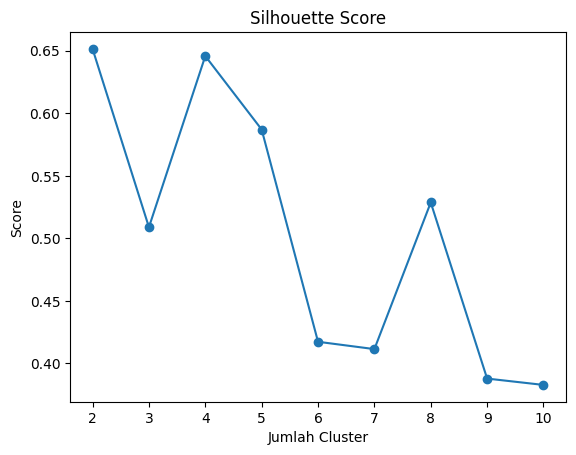

In [ ]:
from sklearn.metrics import silhouette_score

# Hitung Silhouette Score untuk setiap jumlah cluster
silhouette_scores = []
for k in range(2, 11):  # Mulai dari 2 cluster, karena Silhouette tidak valid untuk 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_features)
    score = silhouette_score(latent_features, cluster_labels)
    silhouette_scores.append(score)

# Visualisasi Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Score')
plt.show()


In [ ]:
score = silhouette_score(latent_features, clusters)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.51
